## Note
Since I have an AMD gpu I am running this in a WSL enviorment with ubuntu

In [3]:
#saved for my so I can easily get the kernal up and running
#jupyter notebook --allow-root --NotebookApp.use_redirect_file=False

#needed for my enviornment
#pip install tensorflow==1.15.0
#pip install tensorflow-directml

import tensorflow.compat.v1 as tf 
print(tf.test.gpu_device_name())


/device:DML:0


In [4]:
#testing to make sure the install is up and running
tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 
print(tf.add([1.0, 2.0], [3.0, 4.0])) 
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

tf.Tensor([4. 6.], shape=(2,), dtype=float32)
tf.Tensor(-1879.7161, shape=(), dtype=float32)


### Data and Problem
The data is from the kaggle Histopathologic Cancer Detection competition. It is a large dataset with thousands of tif images. Cancer and other disease detection is an important but expensive process and requires trained professionals with years of experience. Not only would AI help patients with cheaper and faster medical testing but it could also help doctors detect things faster and more accuratly, because even experts can make mistakes, see the radiologists miss gorilla. 

### Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cv2
#import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, optimizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split

In [6]:
test_path = #
train_path = #

labels = pd.read_csv(#)
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)
labels

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


A label of 1 indicates that there is cancer, 0 means no cancer
There are 89117 samples with cancer
There are 130908 samples without cancer
For a total of 220025 samples


<AxesSubplot:>

Samples with cancer make up 0.40503124644926713 of the samples


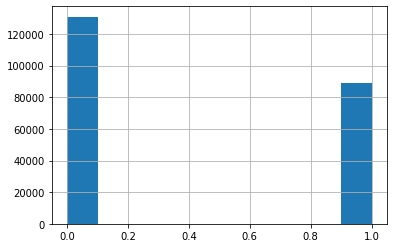

In [7]:
tot=labels['label'].value_counts()
print("A label of 1 indicates that there is cancer, 0 means no cancer")
print("There are", tot[1], "samples with cancer")
print("There are", tot[0], "samples without cancer")
print("For a total of", tot[1]+tot[0], "samples")
display(labels["label"].hist())
print("Samples with cancer make up", tot[1]/(tot[1]+tot[0]), "of the samples")

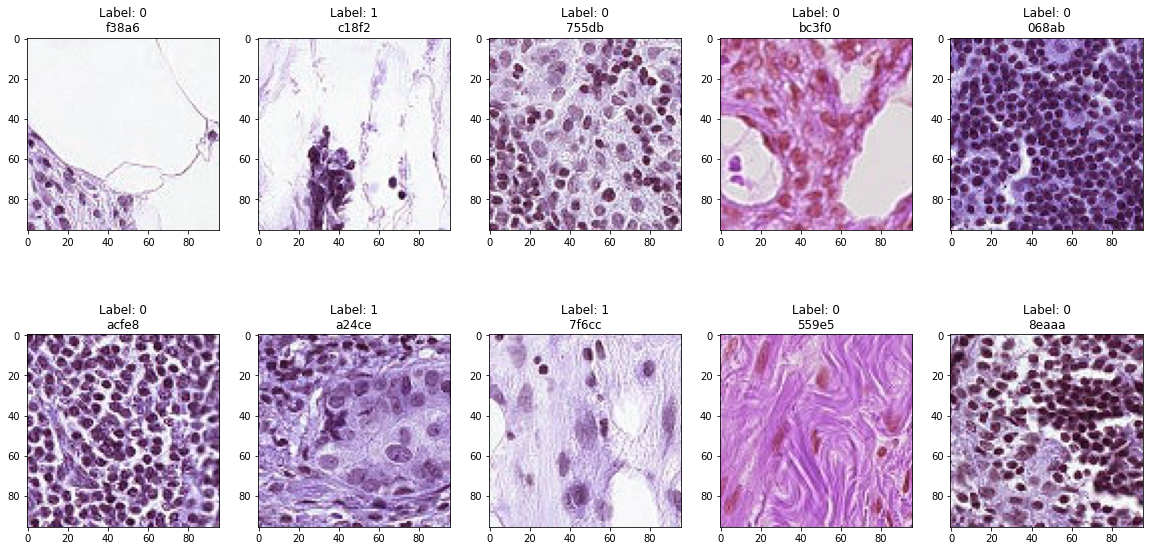

In [8]:
fig, axs = plt.subplots(2, len(labels[:5]), figsize = (20, 10))
for ind, ax in enumerate(axs.ravel()):
    ax.imshow(cv2.imread(train_path + '/' + labels.id[ind] + r".tif"))
    ax.set_title("Label: " + str(labels.label[ind])+"\n"+labels.id[ind][0:5])

In [9]:
labels.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


At first I thought I had the labels missmatched but after double checking that is them. I would not be able to point out the several that have cancer if they weren't already labeled.
### Model

In [10]:
labels["label"] = labels["label"].astype(str)
labels["id"] = labels["id"]+".tif"
#print(len(os.listdir(train_path)))

In [12]:
batch_size=130
datagen = ImageDataGenerator(rescale = 1.0/255.0,validation_split =.2)

In [13]:
#I had a hard time getting the various arguments to work so after I tested that the files validatied I then skipped
#validating for each run because of the time needed
train_generator = datagen.flow_from_dataframe(dataframe = labels, directory = train_path, x_col = "id", y_col = "label",
                                              class_mode = "binary", target_size = (96,96), color_mode = "rgb",
                                              batch_size = batch_size, seed = 123, shuffle = True,
                                              subset = "training", validate_filenames=False)
valid_generator = datagen.flow_from_dataframe( dataframe = labels, directory = train_path, x_col = "id", y_col = "label",
                                              class_mode = "binary", target_size = (96,96), color_mode = "rgb",
                                              batch_size = batch_size, seed = 123, shuffle = True, subset = "validation",
                                              validate_filenames=False)
                                

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.


In [14]:
#I was following a guide that indicated to use a uniform dropout, but I couldn't get that to work so I chose a 
#10% dropout with no theoretical basis for that choice

input__shape=(96,96,3)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=input__shape, activation = "relu"))
model.add(Conv2D(32, (3, 3), activation = "relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3, 3), padding='same', activation = "relu"))

model.add(Conv2D(64, (3, 3), activation = "relu"))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
          
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:DML:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:DML:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:DML:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localho

In [16]:
step_size=train_generator.n//train_generator.batch_size
valid_size=valid_generator.n//valid_generator.batch_size
history=model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size,
                    validation_data=valid_generator,
                    validation_steps=valid_size,
                    epochs=30, verbose =1
)

Epoch 1/30
1354/1354 [==============================] - 1352s 998ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 2/30
1354/1354 [==============================] - 796s 588ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 3/30
1354/1354 [==============================] - 668s 493ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 4/30
1354/1354 [==============================] - 648s 479ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 5/30
1354/1354 [==============================] - 668s 493ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 6/30
1354/1354 [==============================] - 663s 490ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 7/30
1354/1354 [==============================] - 668s 494ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 8/30
1354/1354 [===========

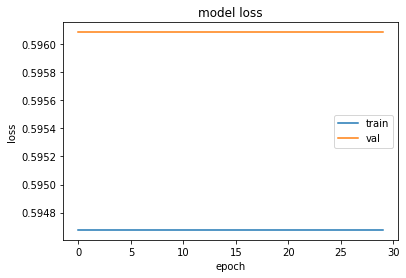

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


In [19]:
#since this is the first time working with a model like this I wanted to see what the different sizes of dropout would do
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding="same",input_shape=input__shape, activation = "relu"))
model2.add(Conv2D(32, (3, 3), activation = "relu"))

model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same', activation = "relu"))

model2.add(Conv2D(64, (3, 3), activation = "relu"))

model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
          
model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.25))
model2.add(Dense(10, activation='softmax'))
model2.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 64)       

In [21]:
history2=model2.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size,
                    validation_data=valid_generator,
                    validation_steps=valid_size,
                    epochs=30
)

Epoch 1/30
1354/1354 [==============================] - 667s 492ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 2/30
1354/1354 [==============================] - 672s 496ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 3/30
1354/1354 [==============================] - 653s 482ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 4/30
1354/1354 [==============================] - 664s 491ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 5/30
1354/1354 [==============================] - 643s 475ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 6/30
1354/1354 [==============================] - 651s 481ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 7/30
1354/1354 [==============================] - 644s 476ms/step - loss: 6.5330 - acc: 0.5947 - val_loss: 6.5103 - val_acc: 0.5961
Epoch 8/30
1354/1354 [============

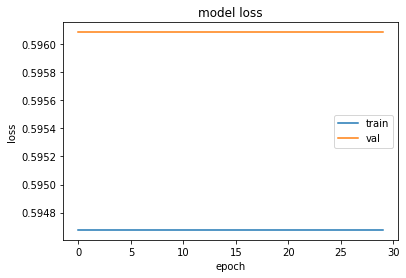

In [25]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [77]:
test_df = pd.DataFrame(test_files)
test_df.columns = ['id']
test_df.head()

,id
0,00006537328c33e284c973d7b39d340809f7271b.tif
1,0000ec92553fda4ce39889f9226ace43cae3364e.tif
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3,000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4,000270442cc15af719583a8172c87cd2bd9c7746.tif


In [78]:
#to be safe I went with a batch size that was also a divisor just like in previous steps
# Needed to use this guide https://stackoverflow.com/questions/52270177/how-to-use-predict-generator-on-new-images-keras
test_datagen=ImageDataGenerator(rescale=1/255)
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory=test_path,
                x_col="id",batch_size=2,seed=123,shuffle=False,color_mode="rgb",
                class_mode=None,target_size=(96,96),validate_filenames=False)

test_generator.reset()                   

Found 57458 non-validated image filenames.


In [91]:
test_size=len(test_generator)
predictor = model2.predict_generator(generator=test_generator,steps=test_size, verbose = 1)

28729/28729 [==============================] - 216s 8ms/step


In [100]:
predicted_class_indices=np.argmax(predictor,axis=1)
results = []
for res in predicted_class_indices:
    if res.all() >= 0.5:
        results.append(1)
    else:
        results.append(0)

In [102]:
submission = test_df.copy()
submission['id']=submission['id'].str[:-4]
submission['label']=results
submission.head()
submission.to_csv('submission.csv',index=False)

### Notes
CNN should have worked well for this project since it needs little preproccesing and can build a complex knowledge off
of small details like this dataset of cancerous and non-cancerours cell images. The key is should have and mine didn't. There are several reasons for this and I hope you'll be gentile on grading.

First, I was constantly fighting with the build of tensorflow and the api levels. For days I couldn't get the model to even build once let alone go through 30 epochs. As it turns out some layer couldn't handle a batch size that left any remainders. I didn't realize this because from what I understood it should be taken care of since it is unlikely that every guide I had read had a dataset that was divisible by a multiple of 8. 

Second, beyond that confounding divisor issue, the build I had to use was of tensorflow 15.1 so either features weren't implimented or how they were called was radically different that any documentation that was readily available. 

Thridly and most importantly, the time required for each step. I have a gpu and although it is a few generations out of date it still took about 20 minutes alone just on filling the shuffle buffer for the first time. This is how it took me several days just to get the batch size right, because I would have to try and trouble shoot and rebuild it and then do something else and come back and hope it worked. I will elaborate on this further in a moment.

### Conclusion
Obviously this is my first time using a CNN and I looked forward to it, machine learning like this is the closes we have to actual AI and not just some fancy matrix multiplication or a regression. However, I had a nightmare as already mentioned on this taking too much time and not for good reasons. I was fighting with the software at every step of the way. The builds I used was out of data and thus lacked current documentation, but I am not sure if it was always that softwares fault. As I am using WSL and although there are files on an offical microsoft website saying its supported I can't help but suspect that there are some issues that arrise from the multiple layers between the software and hardwar. I wasted days trying to get an offical build of ROCm up and running on my machine so I could use modern versions of tensorflow et all, but to no availe. 
Once I gave up and was able to solve the issue of the batch size and other function problems I could finally get this running. As I suspect most of you have found that even mid teir GPUs take hours to run though one model. As a result my simple model failed to learn much then the revision of a greater dropout also failing to learn left me quite upset. As although it was a learning moment that, what I believe to be, the lack of enough convultion layers resulted in the dropout change not haveing a measureable effect I couldn't improve it. Technically I could have however, I cannot leave my PC alone for days on end and thus had to conclude this project. What is worse is that I couldn't even get the predictor function to work right. No matter how many arugments I changed it always output an array of [1,0,0,0,0,0,0,0,0,0] for each of the 57000+ test images. Hence any way I sliced it there was either all 0s or 1s. So my submission to keggle resulted in a score of .5. Which it only got because presumably the test file is half 0s and 1s.
Sorry for the long rant. What a nightmare.
